*************************************
Program fluidsim
Manual initialization of the fields is selected. Do not forget to initialize them.
To plot the forcing modes, you can use:
sim.forcing.forcing_maker.plot_forcing_region()
sim:                <class 'fluidsim.solvers.ns2d.bouss.solver.Simul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.bouss.state.StateNS2DBouss'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>
sim.forcing:        <class 'fluidsim.solvers.ns2d.forcing.ForcingNS2D'>

solver ns2d.bouss, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =    128 ; ny =     32
lx = 4 ; ly = 1
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-02-04
init_f

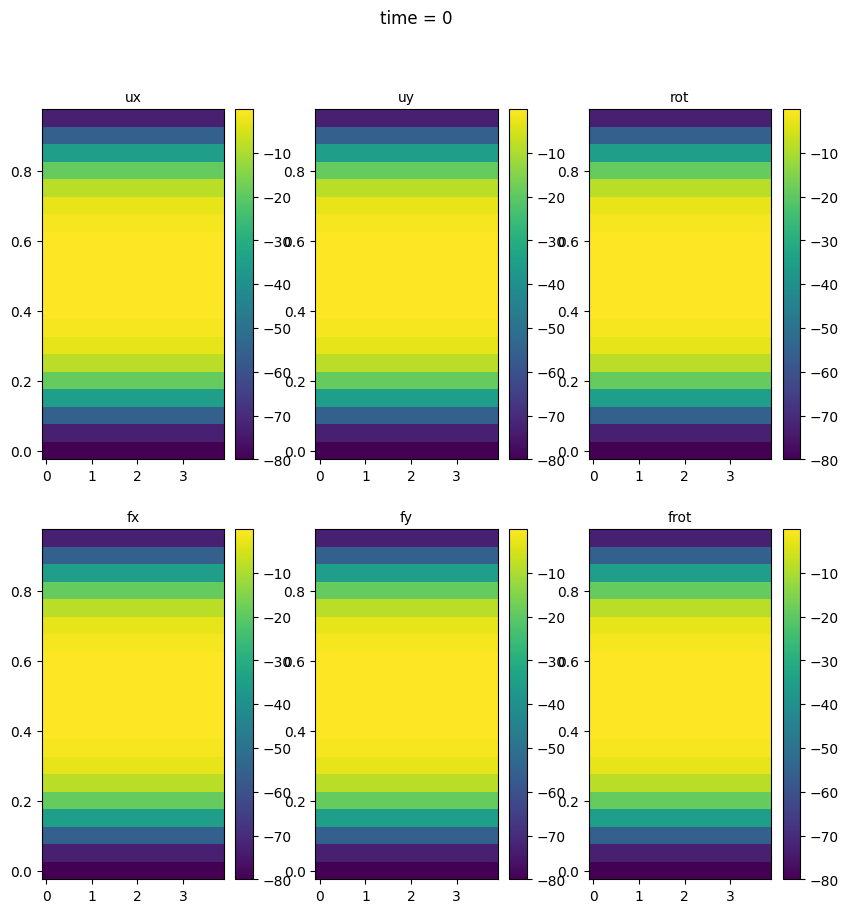

Initialization outputs:
sim.output.increments:        <class 'fluidsim.base.output.increments.Increments'>
sim.output.phys_fields:       <class 'fluidsim.base.output.phys_fields2d.PhysFieldsBase2D'>
sim.output.spatial_means:     <class 'fluidsim.solvers.ns2d.output.spatial_means.SpatialMeansNS2D'>
sim.output.spatiotemporal_spectra:<class 'fluidsim.solvers.ns2d.output.spatiotemporal_spectra.SpatioTemporalSpectraNS2D'>
sim.output.spect_energy_budg: <class 'fluidsim.solvers.ns2d.output.spect_energy_budget.SpectralEnergyBudgetNS2D'>
sim.output.spectra:           <class 'fluidsim.solvers.ns2d.output.spectra.SpectraNS2D'>
sim.output.spectra_multidim:  <class 'fluidsim.solvers.ns2d.output.spectra_multidim.SpectraMultiDimNS2D'>
sim.output.temporal_spectra:  <class 'fluidsim.base.output.temporal_spectra.TemporalSpectra2D'>

Memory usage at the end of init. (equiv. seq.): 316.4765625 Mo
Size of state_spect (equiv. seq.): 0.06656 Mo
*************************************
Beginning of the computati

save state_phys in file state_phys_t007.920.nc
it =    401 ; t =         8.02 ; deltat  =       0.02
              energy = 3.044e-04 ; Delta energy = -2.412e-05

MEMORY_USAGE:                  316.484375 Mo
save state_phys in file state_phys_t008.020.nc
Computation completed in  12.5825 s
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-02-04

To display a video of this simulation, you can do:
cd /home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-02-04
ipython

# then in ipython (copy the 3 lines in the terminal):

from fluidsim import load_sim_for_plot
sim = load_sim_for_plot()

sim.output.phys_fields.animate('uy', dt_frame_in_sec=0.3, dt_equations=0.1)



In [22]:
"""Script for a short simulation with the solver ns2d.bouss

The field initialization is done in the script.

A forcing implemented in the script enforces that there is one static layers in
the top and the bottom of the numerical domain.

"""

import os

import numpy as np
import matplotlib.pyplot as plt

from fluiddyn.util.mpi import rank

from fluidsim.solvers.ns2d.bouss.solver import Simul

if "FLUIDSIM_TESTS_EXAMPLES" in os.environ:
    t_end = 1.0
    nx = 24
else:
    t_end = 10.0
    nx = 128

params = Simul.create_default_params()

params.output.sub_directory = "examples"
params.short_name_type_run = "staticlayer"

params.oper.nx = nx = 128
params.oper.ny = ny = nx // 4

params.oper.Lx = lx = 4
params.oper.Ly = ly = lx * ny / nx

params.oper.coef_dealiasing = 0.7

params.nu_8 = 1e-10

params.time_stepping.t_end = 8.0
# we need small time step for a strong forcing
params.time_stepping.USE_CFL = False
params.time_stepping.deltat0 = 0.02

params.init_fields.type = "in_script"

params.forcing.enable = True
params.forcing.type = "in_script_coarse"
params.forcing.nkmax_forcing = 10

params.output.sub_directory = "examples"
params.output.periods_print.print_stdout = 0.5
params.output.periods_save.phys_fields = 0.1
params.output.periods_save.spatial_means = 0.1

# params.output.periods_plot.phys_fields = 0.2

sim = Simul(params)

# field initialization in the script
rot = 1e-6 * sim.oper.create_arrayX_random()
X = sim.oper.X
Y = sim.oper.Y
x0 = lx / 2
y0 = ly / 2
blob_height = 0.4
blob_width = 0.5
b = -np.exp(-((X - x0) ** 2) / blob_width**2 - (Y - y0) ** 2 / blob_height**2)
sim.state.init_from_rotb(rot, b)

# in this case (params.init_fields.type = 'manual') if we want to plot the
# result of the initialization before the time_stepping, we need to manually
# initialized the output:
#
# sim.output.init_with_initialized_state()
# sim.output.phys_fields.plot(key_field='b')

# monkey-patching for forcing
if rank == 0:

    forcing_maker = sim.forcing.forcing_maker
    oper = forcing_maker.oper_coarse
    Y = oper.Y
    d = ly / 6
    alpha = -80 * (np.exp(-(Y**2) / d**2) + np.exp(-((Y - ly) ** 2) / d**2))

    # on-the-fly plot
    has_to_animate = 1
    if has_to_animate:
        # initialization of the on-the-fly plot
        fig = plt.figure(figsize=(10, 10))
        subplots = fig.subplots(2, 3)
        title = fig.suptitle("time = 0")
        xs = oper.x
        ys = oper.y

        pmeshs = np.empty_like(subplots)
        subtitles = (("ux", "uy", "rot"), ("fx", "fy", "frot"))

        for (i0, i1), ax in np.ndenumerate(subplots):
            pmeshs[i0, i1] = ax.pcolormesh(xs, ys, alpha)
            ax.set_title(subtitles[i0][i1])
            plt.colorbar(mappable=pmeshs[i0, i1], ax=ax)

        plt.pause(1e-3)

    def compute_forcingc_fft_each_time(self):
        """This function is called by the forcing_maker to compute the forcing"""
        rot_fft = self.sim.state.state_spect.get_var("rot_fft")
        rot_fft = self.oper.coarse_seq_from_fft_loc(
            rot_fft, self.shapeK_loc_coarse
        )
        ux_fft, uy_fft = oper.vecfft_from_rotfft(rot_fft)
        ux = oper.ifft(ux_fft)
        uy = oper.ifft(uy_fft)
        fx = alpha * ux
        fy = alpha * uy
        fx_fft = oper.fft(fx)
        fy_fft = oper.fft(fy)
        frot_fft = oper.rotfft_from_vecfft(fx_fft, fy_fft)

        if has_to_animate and sim.time_stepping.it % 10 == 0:
            arrays = np.empty_like(subplots)
            arrays[0, 0] = ux
            arrays[0, 1] = uy
            arrays[0, 2] = oper.ifft(rot_fft)
            arrays[1, 0] = fx
            arrays[1, 1] = fy
            arrays[1, 2] = oper.ifft(frot_fft)

            for (i0, i1), arr in np.ndenumerate(arrays):
                pmesh = pmeshs[i0, i1]
                pmesh.set_array(arr.ravel())
                pmesh.set_clim(arr.min(), arr.max())

            title.set_text(f"time {self.sim.time_stepping.t:.2f}")

            fig.canvas.draw()
            plt.pause(1e-4)

        return frot_fft

    forcing_maker.monkeypatch_compute_forcingc_fft_each_time(
        compute_forcingc_fft_each_time
    )

# and finally time stepping
sim.time_stepping.start()

if rank == 0:
    print(
        "\nTo display a video of this simulation, you can do:\n"
        f"cd {sim.output.path_run}"
        + """
ipython

# then in ipython (copy the 3 lines in the terminal):

from fluidsim import load_sim_for_plot
sim = load_sim_for_plot()

sim.output.phys_fields.animate('uy', dt_frame_in_sec=0.3, dt_equations=0.1)
"""
    )

plt.show()

*************************************
Program fluidsim
sim:                <class 'fluidsim.solvers.ns2d.bouss.solver.Simul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.bouss.state.StateNS2DBouss'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>

solver ns2d.bouss, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =      4 ; ny =      4
lx = 2 ; ly = 2
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_64x32_S2x2_2022-12-26_17-35-58
init_fields.type: constant

Initialization outputs:
sim.output.increments:        <class 'fluidsim.base.output.increments.Increments'>
sim.output.phys_fields:       <class 'fluidsim.base.output.phys_fields2d.PhysFieldsBase2D'>
sim.output.spatial_means:     <clas

ValueError: Argument U has a size 32 which does not match 242, the number of arrow positions

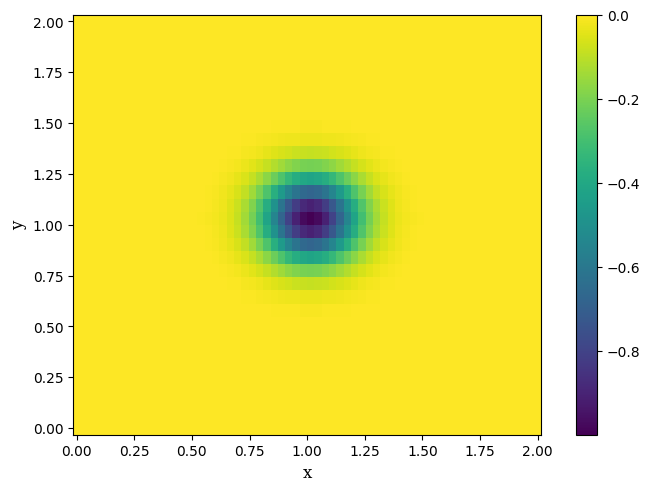

In [3]:
from fluidsim import load_sim_for_plot
sim = load_sim_for_plot(sim.output.path_run)

sim.output.phys_fields.animate('b', dt_frame_in_sec=0.3, dt_equations=0.1)

*************************************
Program fluidsim
Manual initialization of the fields is selected. Do not forget to initialize them.
To plot the forcing modes, you can use:
sim.forcing.forcing_maker.plot_forcing_region()
sim:                <class 'fluidsim.solvers.ns2d.bouss.solver.Simul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.bouss.state.StateNS2DBouss'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>
sim.forcing:        <class 'fluidsim.solvers.ns2d.forcing.ForcingNS2D'>

solver ns2d.bouss, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =    128 ; ny =     32
lx = 4 ; ly = 1
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-04-37
init_f

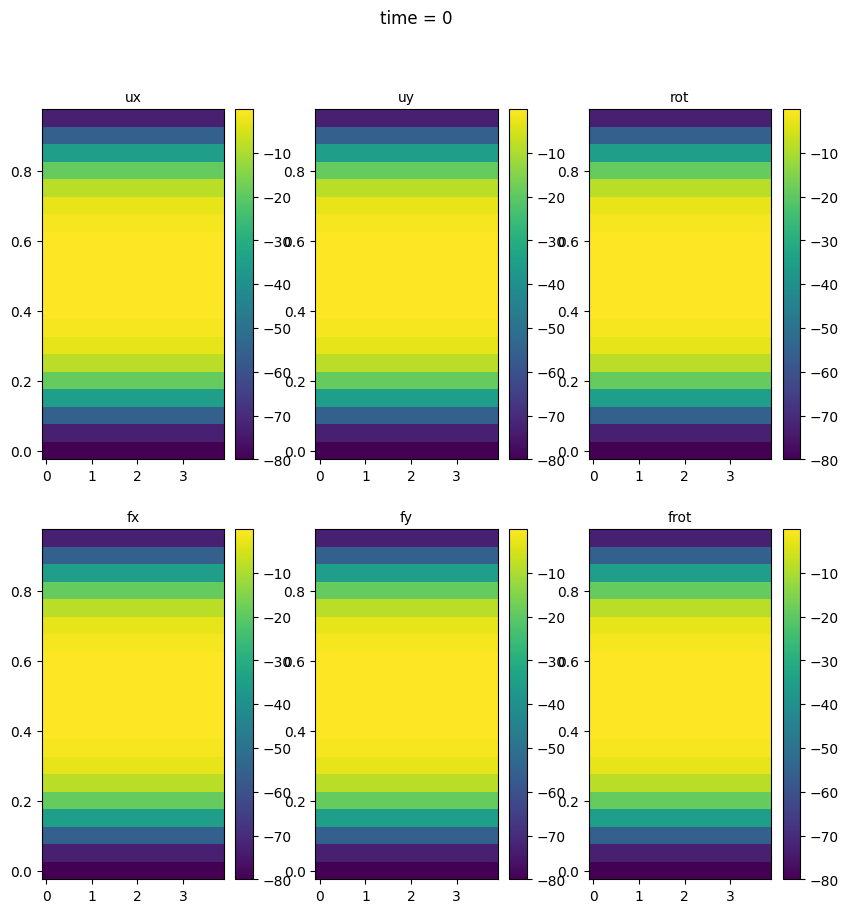

Initialization outputs:
sim.output.increments:        <class 'fluidsim.base.output.increments.Increments'>
sim.output.phys_fields:       <class 'fluidsim.base.output.phys_fields2d.PhysFieldsBase2D'>
sim.output.spatial_means:     <class 'fluidsim.solvers.ns2d.output.spatial_means.SpatialMeansNS2D'>
sim.output.spatiotemporal_spectra:<class 'fluidsim.solvers.ns2d.output.spatiotemporal_spectra.SpatioTemporalSpectraNS2D'>
sim.output.spect_energy_budg: <class 'fluidsim.solvers.ns2d.output.spect_energy_budget.SpectralEnergyBudgetNS2D'>
sim.output.spectra:           <class 'fluidsim.solvers.ns2d.output.spectra.SpectraNS2D'>
sim.output.spectra_multidim:  <class 'fluidsim.solvers.ns2d.output.spectra_multidim.SpectraMultiDimNS2D'>
sim.output.temporal_spectra:  <class 'fluidsim.base.output.temporal_spectra.TemporalSpectra2D'>

Memory usage at the end of init. (equiv. seq.): 322.8359375 Mo
Size of state_spect (equiv. seq.): 0.06656 Mo
*************************************
Beginning of the computati

save state_phys in file state_phys_t007.920.nc
it =    401 ; t =         8.02 ; deltat  =       0.02
              energy = 3.044e-04 ; Delta energy = -2.412e-05

MEMORY_USAGE:                  322.83984375 Mo
save state_phys in file state_phys_t008.020.nc
Computation completed in  12.9505 s
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-04-37

To display a video of this simulation, you can do:
cd /home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_19-04-37
ipython

# then in ipython (copy the 3 lines in the terminal):

from fluidsim import load_sim_for_plot
sim = load_sim_for_plot()

sim.output.phys_fields.animate('uy', dt_frame_in_sec=0.3, dt_equations=0.1)



In [23]:
"""Script for a short simulation with the solver ns2d.bouss

The field initialization is done in the script.

A forcing implemented in the script enforces that there is one static layers in
the top and the bottom of the numerical domain.

"""

import os

import numpy as np
import matplotlib.pyplot as plt

from fluiddyn.util.mpi import rank

from fluidsim.solvers.ns2d.bouss.solver import Simul

if "FLUIDSIM_TESTS_EXAMPLES" in os.environ:
    t_end = 1.0
    nx = 24
else:
    t_end = 10.0
    nx = 128

params = Simul.create_default_params()

params.output.sub_directory = "examples"
params.short_name_type_run = "staticlayer"

params.oper.nx = nx = 128
params.oper.ny = ny = nx // 4

params.oper.Lx = lx = 4
params.oper.Ly = ly = lx * ny / nx

params.oper.coef_dealiasing = 0.7

params.nu_8 = 1e-10

params.time_stepping.t_end = 8.0
# we need small time step for a strong forcing
params.time_stepping.USE_CFL = False
params.time_stepping.deltat0 = 0.02

params.init_fields.type = "in_script"

params.forcing.enable = True
params.forcing.type = "in_script_coarse"
params.forcing.nkmax_forcing = 10

params.output.sub_directory = "examples"
params.output.periods_print.print_stdout = 0.5
params.output.periods_save.phys_fields = 0.1
params.output.periods_save.spatial_means = 0.1

# params.output.periods_plot.phys_fields = 0.2

sim = Simul(params)

# field initialization in the script
rot = 1e-6 * sim.oper.create_arrayX_random()
X = sim.oper.X
Y = sim.oper.Y
x0 = lx / 2
y0 = ly / 2
blob_height = 0.4
blob_width = 0.5
b = -np.exp(-((X - x0) ** 2) / blob_width**2 - (Y - y0) ** 2 / blob_height**2)
sim.state.init_from_rotb(rot, b)

# in this case (params.init_fields.type = 'manual') if we want to plot the
# result of the initialization before the time_stepping, we need to manually
# initialized the output:
#
# sim.output.init_with_initialized_state()
# sim.output.phys_fields.plot(key_field='b')

# monkey-patching for forcing
if rank == 0:

    forcing_maker = sim.forcing.forcing_maker
    oper = forcing_maker.oper_coarse
    Y = oper.Y
    d = ly / 6
    alpha = -80 * (np.exp(-(Y**2) / d**2) + np.exp(-((Y - ly) ** 2) / d**2))

    # on-the-fly plot
    has_to_animate = 1
    if has_to_animate:
        # initialization of the on-the-fly plot
        fig = plt.figure(figsize=(10, 10))
        subplots = fig.subplots(2, 3)
        title = fig.suptitle("time = 0")
        xs = oper.x
        ys = oper.y

        pmeshs = np.empty_like(subplots)
        subtitles = (("ux", "uy", "rot"), ("fx", "fy", "frot"))

        for (i0, i1), ax in np.ndenumerate(subplots):
            pmeshs[i0, i1] = ax.pcolormesh(xs, ys, alpha)
            ax.set_title(subtitles[i0][i1])
            plt.colorbar(mappable=pmeshs[i0, i1], ax=ax)

        plt.pause(1e-3)

    def compute_forcingc_fft_each_time(self):
        """This function is called by the forcing_maker to compute the forcing"""
        rot_fft = self.sim.state.state_spect.get_var("rot_fft")
        rot_fft = self.oper.coarse_seq_from_fft_loc(
            rot_fft, self.shapeK_loc_coarse
        )
        ux_fft, uy_fft = oper.vecfft_from_rotfft(rot_fft)
        ux = oper.ifft(ux_fft)
        uy = oper.ifft(uy_fft)
        fx = alpha * ux
        fy = alpha * uy
        fx_fft = oper.fft(fx)
        fy_fft = oper.fft(fy)
        frot_fft = oper.rotfft_from_vecfft(fx_fft, fy_fft)

        if has_to_animate and sim.time_stepping.it % 10 == 0:
            arrays = np.empty_like(subplots)
            arrays[0, 0] = ux
            arrays[0, 1] = uy
            arrays[0, 2] = oper.ifft(rot_fft)
            arrays[1, 0] = fx
            arrays[1, 1] = fy
            arrays[1, 2] = oper.ifft(frot_fft)

            for (i0, i1), arr in np.ndenumerate(arrays):
                pmesh = pmeshs[i0, i1]
                pmesh.set_array(arr.ravel())
                pmesh.set_clim(arr.min(), arr.max())

            title.set_text(f"time {self.sim.time_stepping.t:.2f}")

            fig.canvas.draw()
            plt.pause(1e-4)

        return frot_fft

    forcing_maker.monkeypatch_compute_forcingc_fft_each_time(
        compute_forcingc_fft_each_time
    )

# and finally time stepping
sim.time_stepping.start()

if rank == 0:
    print(
        "\nTo display a video of this simulation, you can do:\n"
        f"cd {sim.output.path_run}"
        + """
ipython

# then in ipython (copy the 3 lines in the terminal):

from fluidsim import load_sim_for_plot
sim = load_sim_for_plot()

sim.output.phys_fields.animate('uy', dt_frame_in_sec=0.3, dt_equations=0.1)
"""
    )

plt.show()

*************************************
Program fluidsim
sim:                <class 'fluidsim.solvers.ns2d.bouss.solver.Simul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.bouss.state.StateNS2DBouss'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>
sim.forcing:        <class 'fluidsim.solvers.ns2d.forcing.ForcingNS2D'>

solver ns2d.bouss, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =      4 ; ny =      4
lx = 4 ; ly = 1
path_run =
/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_17-49-11
init_fields.type: constant

Initialization outputs:
sim.output.increments:        <class 'fluidsim.base.output.increments.Increments'>
sim.output.phys_fields:       <class 'flui

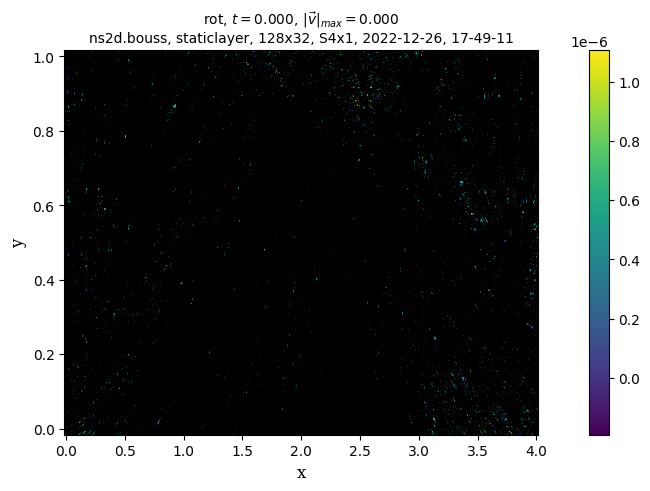

In [14]:
from fluidsim import load_sim_for_plot
sim = load_sim_for_plot(sim.output.path_run)

sim.output.phys_fields.animate('vy', dt_frame_in_sec=50, dt_equations=4.01)



In [15]:
sim.output.path_run

'/home/nikhil/Sim_data/examples/ns2d.bouss_staticlayer_128x32_S4x1_2022-12-26_17-49-11'